In [0]:
"""
Simulates no-slip billiards on polygon shaped tables
"""

# standard imports 
from pylab import *
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')


# set any global variable
epsilon = 1e-5 #tolerance for comparing time and distances


def create_table(x,y):
    """
    Creates a billiard table given x and y coordiantes 

    Parameters
    ----------
    coordinates: numpy array
        x and y coordinates of all table corners

    Raises
    ------
    error: when there are less than 3 pairs of points

    Returns
    -------
    table: numpy array 
        an array with each row containing a wall's starting point, ending 
    point, direction vector, curve type, and collision type 
    """
    nw = len(x)
    if nw < 3:
        raise Exception('Error: You need at least three sets of points.')

    #set curve type for each wall MANUALLY;  1 for line, 0 for circle. 
    #Default is all lines
    curve_type = [1]*nw

    #set collision type for each wall MANUALLY; 0 for specular/smooth, 1 for rough/spin.
    #default is all smooth
    collision_type = [0]*nw 

    #initialize the table.
    table =  []

    #build the walls.
    for i in range(nw):
        x0,y0 = x[i], y[i]

        #when at the final vertex, next coordinate needs to be the initial vertex.
        if i ==  nw-1:
            i = -1             
        x1,y1 = x[i+1], y[i+1]
        xdot0, ydot0 = (x1-x0)/distance(x0,y0,x1,y1), (y1-y0)/distance(x0,y0,x1,y1)

        #append the walls to the table one by one.
        table = np.append(table, [x0,y0,x1,y1,xdot0, ydot0, curve_type[i], collision_type[i]])

    #reshape the table to correct dimensions.   
    table = np.reshape(table, (nw,8))

    return np.asarray(table)    

  
def create_ngon(nw,length):
    """
    Creates a regular polygon shaped billiard table

    Parameters
    ----------
    nw: int
      number of walls
    length: float
      length of each side

    Returns
    -------
    table: numpy array 
        an array with each row containing the wall's starting point, ending 
    point, direction verctor, curve type, and collision type 
    """
    table = []
    xstart,ystart = [length,0]
    ux,uy = [-1,0]
    xend,yend = length*np.array([0,0])
    c = 1 #curve type = line
    m = 0 #collision type = smooth
    table =  np.array([xstart, ystart, xend, yend, ux, uy, c, m])
    theta = 2*math.pi/nw #interior angle is 2*pi/number of sides
    
    for i in range(1,nw):
        #Plot the particular wall.       
        xstart = xend
        ystart = yend
        uxinit = ux
        uyinit = uy
        uxfinal = cos(theta)*uxinit + sin(theta)*uyinit
        uyfinal = -sin(theta)*uxinit + cos(theta)*uyinit
        xend = xstart + length*uxfinal
        yend = ystart + length*uyfinal
        ux = uxfinal
        uy = uyfinal
        table = np.append(table,[xstart, ystart, xend, yend, ux, uy, c, m], axis=0)

    table = np.reshape(table,(nw,8))
    return table

def plot_table(table):
    plt.plot([table[:,0],table[:,2]], [table[:,1],table[:,3]], 'k-', lw=2)
    plt.axis('equal')
  
def slope(x1,y1,x2,y2):
    """ A function to calculate slope"""
    return (y2-y1)/(x2-x1) 
  
def distance(x1,y1,x2,y2):
    """ A function to calculate distance"""
    return ((x2-x1)**2 + (y2-y1)**2)**0.5

def is_between(ax,ay,bx,by,cx,cy):
    """A function to determine if a point (cx,cy) lies between two other points
    (ax,ay) and (bx,by)
    """
    return np.abs((distance(ax,ay,cx,cy)
                  + distance(cx,cy,bx,by) 
                  - distance(ax,ay,bx,by))) < epsilon

def rotation(theta):
    """ Returns a 3X3 clockwise rotation matrix around x-xis"""
    return np.array([[1,0,0],
                    [0,cos(theta), -sin(theta)],
                  [0,sin(theta), cos(theta)]])

def reflection(gamma):
    """ Returns a 3X3 reflection matrix (T_gamma) where gamma is the 
    mass distribution constant"""
    return np.array([[-(1-gamma**2)/(1+gamma**2), -2*gamma/(1+gamma**2),0],
                            [-2*gamma/(1+gamma**2),(1-gamma**2)/(1+gamma**2),0],
                          [0,0,-1]])
    
def parametrized_length(table, x_col,y_col,wall_index,nw):
    """A function to calculate the parametrized length at the collision point"""
    table_length = 0
    col_length = 0
    for i in range(nw):
        x1,y1,x2,y2 = table[i][0:4]
        
        #find wall length up to the collision point
        if i < wall_index:
            col_length += ((x2-x1)**2 + (y2-y1)**2)**0.5
            
        #add the right fraction of the final wall
        if i == wall_index:
            col_length += ((x_col-x1)**2 + (y_col-y1)**2)**0.5
            
        #find the table length by adding each wall
        table_length += ((x2-x1)**2 + (y2-y1)**2)**0.5
        
    #parametrize s as a fraction of total table length.
    s = col_length/table_length   
    return s

def reflection_vector(table, x_col,y_col,omega0,xdot0,ydot0,wall_index,gamma):
    """
    Returns the reflection vector after collision
    Also returns the reflection vector measured along the tangent and phase angle 
    along the tangent
    """
    wall_index = int(wall_index)
    vector_in = np.array([omega0,xdot0,ydot0])

    #find wall vector
    wall_x = table[wall_index,4]
    wall_y = table[wall_index,5]
    wall_dir = np.array([wall_x, wall_y])

    #create 90 deg clockwise rotation matrix to get normal
    rot_mat_clockwise_ninety = np.array([[cos(math.pi/2), sin(math.pi/2)],
                                  [-sin(math.pi/2), cos(math.pi/2)]])

    #find the normal by rotating the wall clockwise 90 degrees
    normal = np.matmul(rot_mat_clockwise_ninety,wall_dir)

    #change normal to a 3D vector
    normal = np.append(normal, [0])
    #print(normal)

    #find the angle between normal and y-axis
    theta = math.acos(np.dot(normal,[0,1,0]))


    #find out how much anti-clockwise rotation is needed to align the normal with y-axis
    temp_num =  np.cross(normal, [0,1,0])[2]
    if temp_num < 0:                   
        theta = 2*math.pi-theta

    #create anti-clockwise rotation matrix
    rot_mat = rotation(theta)
    
    #create reflection matrix
    reflect_mat = reflection(gamma)

    #Find the reflection vector through matrix transformation
    vector_out = rot_mat@vector_in
    vector_out_tangent = reflect_mat@vector_out
    vector_out = np.transpose(rot_mat)@vector_out_tangent

    #find phase angle, phi
    phi = math.acos(np.dot(vector_out[1:],normal[:2]))

    temp = np.append(vector_out,vector_out_tangent)
    return np.append(temp,phi)
    
def collision(table,x0,y0,omega0,xdot0,ydot0,gamma):
    """
    Takes in the current state, performs collision and returns the next state
    """
    #initialize collision output matrix to store collision results for each wall
    col_mat = []

    #compute collision times for all walls.
    nw = table.shape[0]
    for i in range(nw):
        x1,y1,x2,y2 = table[i][0:4]
        vx_wall,vy_wall = table[i][4:6]
        
        #step 1: check for walls with undefined slope.
        #if there is one, find the collision point and wall index.
        if x1 == x2: 
            t = (x1-x0)/xdot0
            x = x1
            y = y0 + ydot0*t
            col_mat = np.append(col_mat,[x,y,t,i])
            
        #step 1: check for walls parallel to direction vector    
        elif abs(np.cross([vx_wall,vy_wall], [xdot0,ydot0])) < epsilon:
            col_mat = np.append(col_mat,[100,100,-1,i])
            
        #step 3: compute collision times for remaining walls with defined slopes.  
        else:    
            m = slope(x1,y1,x2,y2)
            b = np.array([x0,y0,y1-m*x1])
            A = np.array([[1,0,-xdot0],
                [0,1,-ydot0],
                [-m,1,0]])
            A_inverse = np.linalg.inv(A) 
            col_mat = np.append(col_mat,np.append(np.matmul(A_inverse,b),[i])) 

    #reshape the collision matrix for all walls
    col_mat = np.reshape(col_mat, (nw,4))
    
    temp = []
    counter = 0
    for i in range(nw):
        ax,ay,bx,by = table[i][0:4]
        cx = col_mat[i][0]
        cy = col_mat[i][1]
        col_time = col_mat[i][2]

        if is_between(ax,ay,bx,by,cx,cy):
            temp = np.append(temp,col_mat[i,:],axis = 0)
            counter += 1
    #temp is the matrix with collision points that lie on the walls         
    temp = np.reshape(temp,(counter,4))

    #find the minimum time out of the sorted walls
    min_time = min([n for n in temp[:,2]  if n > epsilon]) 

    #find the row number for the minimum 
    row_number, column = np.where(temp == min_time)

    #extract the wall with minimum positive collision time        
    col_output = temp[row_number,:]

    #extract collision parameters
    x_col, y_col, t_col, wall_index = col_output[0,:]

    #find the reflection vector and the phase angle phi, returns, vx_out,_vy_out, phi
    vector_out = reflection_vector(table, x_col,y_col,omega0,xdot0,ydot0,wall_index,gamma)

    #find the parameterized length of the collision point and append it to the output
    s = parametrized_length(table, x_col,y_col,wall_index,nw) 

    #append parametrized length, vector out, and phase angle to collision output
    col_output = np.append(col_output,s)
    col_output = np.append(col_output,vector_out)    

    return np.asarray(col_output)


#this functions runs the simulation and outputs a numpy array 
def polygon_sim(table,init_pos,init_vel,count,gamma):
    """
    A function to initialize the simulation.
  
    Parameters
    ----------
    table: numpy array
      table with all wall specifications
    init_pos: numpy array or list, 
      [x0,y0], initial position of the particle
    init_vel: numpy array or list
      [omega0,xdot0,ydot0], initial velocity of the particle including the spin
    count: int, collision count
    gamma: float, mass distribution constant of the colliding particle
    
    Returns
    -------
    output: numpy array
      each row has [x0,y0,xdot0,ydot0,s,phi] 
      s is patamertized length and phi is phase angle along the tangent
      
    """
    x0,y0 = init_pos
    omega0,xdot0,ydot0 = init_vel
    
    #Normalize the input vector
    omega_unit = omega0/((xdot0**2 + ydot0**2 + omega0**2))**0.5
    xdot0_unit = xdot0/((xdot0**2 + ydot0**2 + omega0**2))**0.5
    ydot0_unit = ydot0/((xdot0**2 + ydot0**2 + omega0**2))**0.5   
    xdot0 = xdot0_unit
    ydot0 = ydot0_unit
    omega0 = omega_unit
    nw = len(table[:,0])

    #Plot the table
    for i in range(nw):
        x1x2 = [table[i][0],table[i][2]]
        y1y2 = [table[i][1],table[i][3]]
        #plt.plot(x1x2, y1y2, 'k-', lw=2) 
    output = []
    n = 0

    #Find the parameters after collision
    while n < count:
        c = collision(table,x0,y0,omega0,xdot0,ydot0,gamma)
        [xtemp,ytemp,ttemp,itemp,s,omegatemp,xdottemp,ydottemp,omega_tang,xdot_tang,ydot_tang,phi] = c
        itemp = int(itemp)
        #plt.plot([x0,xtemp], [y0,ytemp], 'k-', lw=0.25) 
        x0 = xtemp
        y0 = ytemp
        omega0 = omegatemp
        xdot0 = xdottemp
        ydot0 = ydottemp
        output = np.append(output,[x0,y0,omega_tang,xdot_tang,ydot_tang,s,phi], axis=0)
        n = n+1
    output = np.reshape(output, (n,7))
    
    #Return simulation outout, that is, [x0,y0,xdot0,ydot0,s,phi]
    return np.array(output)

def plot_trajectory(output):
    """Plots the trajectory of the particle"""
    for i in range(output.shape[0]-1):
      plt.plot([output[i,0], output[i+1,0]], [output[i,1], 
                                              output[i+1,1]], 'k-', lw=0.25) 


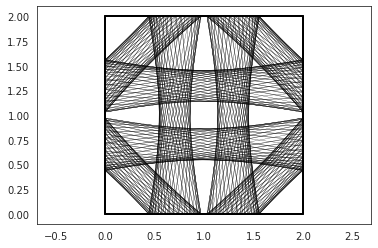

In [0]:
#######################################
########## SQUARE SHAPED TABLE ########

#this a test for walls with undefined slopes

#set simulation parameters
n_col = 500
gamma = 1/sqrt(2) #uniform mass distribution

#create table
square = create_ngon(4,2)

#set initial conditions
init_pos = [0.5,0.25]
init_vel = [-1,0.2,1]

#simulate no-slip billiard
out = polygon_sim(square,init_pos,init_vel,n_col,gamma)

#plot the table
plot_table(square)

#plot the trajectory
plot_trajectory(out)

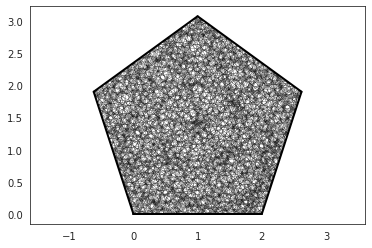

In [0]:
#######################################
####### PENTAGON SHAPED TABLE #########

#set simulation parameters
n_col = 500
gamma = 0 #point mass

#create table
pentagon = create_ngon(5,2)

#set initial conditions
init_pos = [0.12,0.25]
init_vel = [-1,0.2,1]

#simulate no-slip billiard
out = polygon_sim(pentagon,init_pos,init_vel,n_col,gamma)

#plot the table
plot_table(pentagon)

#plot the trajectory
plot_trajectory(out)

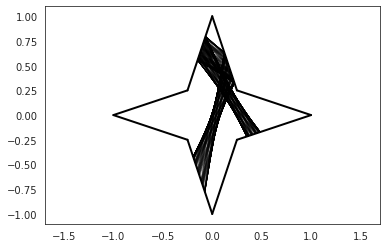

In [0]:
#############################################
############# STAR SHAPED TABLE #############

#set simulation parameters
n_col = 500
gamma = 1 # mass on boundary like a ring

#create table
star = create_table([-1,-0.25,0,0.25,1,0.25,0,-0.25],[0,0.25,1,0.25,0,-0.25,-1,-0.25])

#set initial conditions
init_pos = [0.12,0.25]
init_vel = [-1,0.2,1]

#simulate no-slip billiard
out = polygon_sim(star,init_pos,init_vel,n_col,gamma)

#plot the table
plot_table(star)

#plot the trajectory
plot_trajectory(out)


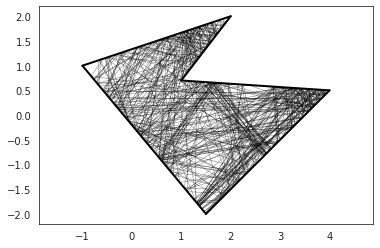

In [0]:
#############################################
##### TABLE WITH AN ARBITRARY SHAPE #########

#set simulation parameters
n_col = 500
gamma = 0.23 # arbitrary mass distribution 

#create table with arbitrary shape
arb = create_table([-1,2,1,4,1.5],[1,2,0.7,0.5,-2])

#set initial conditions
init_pos = [0.5,0.5]
init_vel = [-1,0,1]

#simulate no-slip billiard
out = polygon_sim(arb,init_pos,init_vel,n_col,gamma)

#plot the table
plot_table(arb)

#plot the trajectory
plot_trajectory(out)
